# PPO, R-PPO and VAE comparison

In [ ]:
from runner import run
from parameters import Parameters, VAEParameters, PPOParameters, RPPOParameters

params = Parameters(agent=PPOParameters(entropy_c2=0.025), n_episodes=4000)
for p in params.repeat(10):
    run(p)

params = Parameters(agent=RPPOParameters(entropy_c2=0.025), n_episodes=4000)
for p in params.repeat(10):
    run(p)

params = Parameters(agent=VAEParameters(), n_episodes=4000)
for p in params.repeat(10):
    run(p)

## Score over training time

Loaded 6 logs from logs/ppo-transition-normalized-rewards-no-exp
Loaded 9 logs from logs/ppo-transition-not-normalized-rewards-no-exp
Loaded 1 logs from logs/ppo-transition-normalized-rewards-cholesky/
Loaded 10 logs from logs/ppo-transition-normalized-rewards-no-exp-normalized-advantages


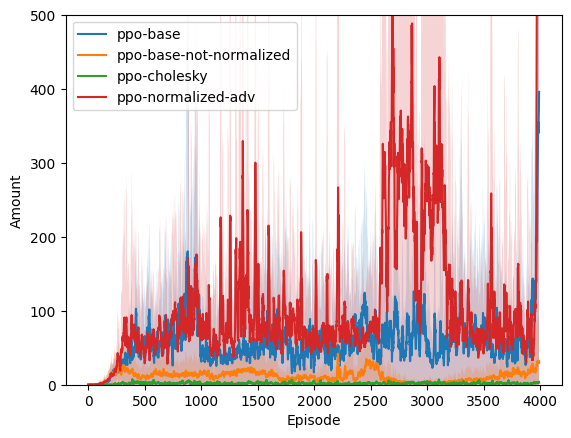

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from plots import Experiment

logdirs = {
    "ppo-base": "logs/ppo-transition-normalized-rewards-no-exp",
    "ppo-base-not-normalized": "logs/ppo-transition-not-normalized-rewards-no-exp",
    "ppo-cholesky": "logs/ppo-transition-normalized-rewards-cholesky/",
    "ppo-normalized-adv": "logs/ppo-transition-normalized-rewards-no-exp-normalized-advantages",
    # "ppo-exp": "logs/ppo-transition-normalized-rewards-exp",
    # "vae-base": "logs/vae/2025-05-21T17-58-17.921210/",
    # "vae-40t": "logs/vae/2025-05-21T20-22-56.256023/",
    # "vae-40t-20hidden": "logs/vae/2025-05-21T20-28-41.368225/"
}

def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), "valid") / w

for label, logdir in logdirs.items():
    exp = Experiment.from_directory(logdir)

    mean = np.mean(exp.amounts_over_time, axis=0)
    mean = moving_average(mean, 10)
    std  = np.std(exp.amounts_over_time, axis=0)
    std = moving_average(std, 10)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Amount")
plt.ylim(0, 500)
plt.legend()



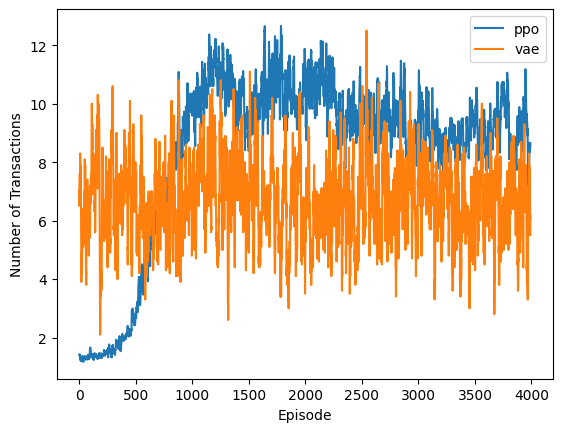

In [ ]:
for label, logdir in logdirs.items():
    exp = Experiment.from_directory(logdir)

    mean = np.mean(exp.n_transactions_over_time, axis=0)
    mean = moving_average(mean, 10)
    plt.plot(mean, label=label)
    # plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Number of Transactions")
plt.legend()


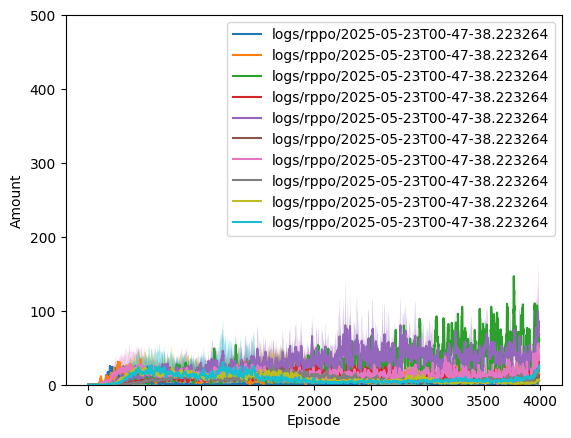

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from plots import Experiment
import os
from environment.priority_queue import PriorityQueue

prefix = os.path.join("logs", "rppo")
logdirs = os.listdir(prefix)
# logdirs = ["2025-05-23T00-47-38.363831/"]

def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), "valid") / w


total = PriorityQueue[Experiment]()

for logdir in logdirs:
    logdir = os.path.join(prefix, logdir)
    exp = Experiment.from_directory(logdir)
    if exp.n_runs == 0:
        continue
    total.push(exp, exp.total_amount)
    # print(logs.amounts_over_time.shape)
    # 

for i in range(10):
    exp = total.pop()
    mean = np.mean(exp.amounts_over_time, axis=0)
    mean = moving_average(mean, 10)
    std = np.std(exp.amounts_over_time, axis=0)
    std = moving_average(std, 10)
    plt.plot(mean, label=logdir)
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.4)
plt.xlabel("Episode")
plt.ylabel("Amount")
plt.ylim(0, 500)
plt.legend()


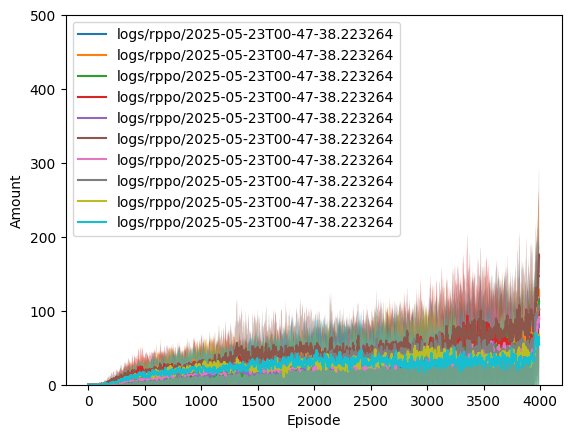

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from plots import Experiment
import os
from environment.priority_queue import PriorityQueue

prefix = os.path.join("logs", "rppo")
logdirs = os.listdir(prefix)
# logdirs = ["2025-05-23T00-47-38.363831/"]


def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), "valid") / w


total = PriorityQueue[Experiment]()

for logdir in logdirs:
    logdir = os.path.join(prefix, logdir)
    exp = Experiment.from_directory(logdir)
    if exp.n_runs == 0:
        continue
    total.push(exp, -exp.total_amount)
    # print(logs.amounts_over_time.shape)
    #

for i in range(10):
    exp = total.pop()
    mean = np.mean(exp.amounts_over_time, axis=0)
    mean = moving_average(mean, 10)
    std = np.std(exp.amounts_over_time, axis=0)
    std = moving_average(std, 10)
    plt.plot(mean, label=logdir)
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.4)
plt.xlabel("Episode")
plt.ylabel("Amount")
plt.ylim(0, 500)
plt.legend()
